# Applied Data Science Capstone - Final Project

##### This notebook holds code for the Applied Data Science Capstone course final project. ( Part of the IBM Data Science Professional Certification )

## Where to Open your Pizza Place? - With the Power of Clustering

If you are someone in Stockholm County looking for an excellent location to open a pizza place of your own, this could help you.

How about finding a group of similar neighbourhoods in Stockholm with pizza places as the most common venue type for most neighbourhoods?

Neighbourhoods with well-established pizza place businesses should be good for your new business, too, only if there are not too many similar businesses already in the neighbourhood. That is why this solution gives you not one neighbourhood but also find similar neighbourhoods. So if you have too many well-established and flourishing pizza place businesses in a neighbourhood, you can go for a similar neighbourhood (based on your other specific requirements), which does not have too many of such joint but does have a potential for profits for a new joint if you open one.

Confusing, was it? Let me explain this to you through steps. With the result in hand, the idea clarifies further.

### Step 1: Import all the required libraries.

Before you start creating models to solve any problem, you need to gather, cleanse and most importantly, explore data. You use many utility functions, classes, and induction models with which you train your data. Let us import all the libraries required for our analysis.

In [1]:
# library for data manipulations and analyses
import pandas as pd

# customise row/column display aspects
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# library for similar manipulation making use of vectors
import numpy as np

# library for HTTP requests
import requests

# library for converting address into latitude and longitude values
from geopy.geocoders import Nominatim

# library for map rendering
!pip install folium
import folium

# scipy's cdist for determining optimal K in K-Means clustering
from scipy.spatial.distance import cdist

# sklearn's KMeans for clustering
from sklearn.cluster import KMeans

# library for colors on maps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

##### Note: We are using ```Folium``` for map visualisations in this code, but for some reason, ```Folium``` maps are not visible on the GitHub .ipynb files. Nevertheless, we have placed map image files in this repository separately.

### Step 2: Gather data for analysis.

To fetch the venue information from the Foursquare API, we need the geocoordinate information of the Stockholm neighbourhoods. Once we have this information, we can use the latitudes and longitudes to find out the venues in each neighbourhood.

For this data, we use the data present in the ```SE.zip``` file present at ```http://download.geonames.org/export/zip/```. This file consists of the Stockholm County postal code level latitude and longitude information and other information such as district name, municipal name and municipal code.

If you download and unzip the ```SE.zip``` file, you will find that the information we need is present in the text file named ```SE.txt```. This file has been uploaded to the same repository as this notebook (```SE_geo_data.txt```) and is being used directly for convenience. 

In [2]:
# data file URL from GitHub
data_URL = 'https://raw.githubusercontent.com/guptasaumya/coursera-capstone-final/master/SE_geo_data.txt'

# load data into pandas data frame
postal_geocoordinate_data = pd.read_csv(data_URL,
                                        # data file is tab seperated
                                        delimiter="\t",
                                        # file as no column headers
                                        header=None,
                                        # read only the required information
                                        usecols=[2, 3, 9, 10],
                                        names=["Neighbourhood", "County", "Latitude", "Longitude"])

postal_geocoordinate_data.head()

,Neighbourhood,County,Latitude,Longitude
0,Vallentuna,Stockholm,59.5344,18.0776
1,Vallentuna,Stockholm,59.5344,18.0776
2,Brottby,Stockholm,59.5632,18.2403
3,Vallentuna,Stockholm,59.5344,18.0776
4,Vallentuna,Stockholm,59.5344,18.0776


We now have a couple of pre-processing to be done on this data. Since we are dealing in Stockholm County, we remove all the postal codes belonging to counties other than Stockholm. Then we drop the ```County``` column since we have no use left of it.

In [3]:
# remove data of other counties
stockholm_data = postal_geocoordinate_data[postal_geocoordinate_data.County == "Stockholm"].drop("County", axis=1)

# remove column not needed
stockholm_data = stockholm_data[["Neighbourhood", "Latitude", "Longitude"]]

stockholm_data.head()

,Neighbourhood,Latitude,Longitude
0,Vallentuna,59.5344,18.0776
1,Vallentuna,59.5344,18.0776
2,Brottby,59.5632,18.2403
3,Vallentuna,59.5344,18.0776
4,Vallentuna,59.5344,18.0776


We see more than one row for each district because of multiple postal codes within the district. Remember, this is postal codes data. However, we find that the geocoordinate information for all postal codes within a district is the same, indicating a lack of exact data. It is the case with most of the districts but not all. Hence to keep consistency, we remove the duplicates using the ```Neighbourhood``` subset. It results in one postal code per district of Stockholm County with its geocoordinate information.

In [4]:
# remove duplicate rows
stockholm_data.drop_duplicates(subset = ['Neighbourhood'], inplace=True)

Then we make consistent the spelling of the municipalities - Järfälla and Norrtälje in the data.

In [5]:
# correct naming inconsistency
stockholm_data = stockholm_data[~stockholm_data["Neighbourhood"].isin(["Norrtalje", "Järfalla"])]

We end up with geocoordinate data for 121 districts of Stockholm County.

In [6]:
# check shape (row represent number of districts in Stockholm county)
print(stockholm_data.shape)

stockholm_data.head()

(121, 3)


,Neighbourhood,Latitude,Longitude
0,Vallentuna,59.5344,18.0776
2,Brottby,59.5632,18.2403
43,Ingmarsö,59.4675,18.7494
44,Åkersberga,59.4794,18.2997
45,Ljusterö,59.5275,18.6211


### Step 3: Visualise the neighbourhoods/postal codes coordinates on the Stockholm County map.

We will cluster these 121 districts based on the frequency of various types of venues within them. We start by first placing each of the districts on the map of Stockholm County using ```Folium```.

In [7]:
# use geopy library to get latitude and longitude values of city of Stockholm
address = "Stockholm, Sweden"

geolocator = Nominatim(user_agent="stockholm_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Stockholm using latitude and longitude values
map_stockholm = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, Neighbourhood in zip(stockholm_data["Latitude"],
                                  stockholm_data["Longitude"],
                                  stockholm_data["Neighbourhood"]):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm)

map_stockholm

##### Note: For this map result, check out https://github.com/guptasaumya/coursera-capstone-final/blob/master/map_Stockholm.png in this repository.

Now that we have the information of the geocoordinates of the Stockholm County districts, we can use it to get the venues data using the Foursquare API. We are trying to get the information on the most common venue categories for the districts and use this information for clustering.

### Step 4: Define Foursquare API usage credentials and version.

In order to use the Foursquare API, we define some API query parameters. The following cell consists of client credentials and hence have been marked hidden by the owner.

In [8]:
# The code was removed by Watson Studio for sharing.

We also define the ```VERSION``` and ```LIMIT``` parameters as follows. The former defines the API version we want to access (by date), and the latter defines the number of results to return.

In [9]:
# define Foursquare API version
VERSION = '20210816'

# define Foursquare API limit value
LIMIT = 100

### Step 5: Retrieve all venues for the districts within 500 meters radius.

We now define a function to retrieve nearby venues for each of these districts. The function will return multiple rows corresponding to each district.

In [10]:
# define function gets nearby venues for each district
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    # 'venues_list' stores venues data for all postal codes in list of lists format
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name)

        # create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # send GET requests and examine results
        response = requests.get(url).json()["response"]['groups'][0]['items']

        # append only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in response])

    # create data frame from list of lists containing PostalCode data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list
                                  for item in venue_list])
    
    # rename columns for uniform column name format
    nearby_venues.columns = ['Neighbourhood',
                             'NeighbourhoodLatitude',
                             'NeighbourhoodLongitude',
                             'Venue',
                             'VenueLatitude',
                             'VenueLongitude',
                             'VenueCategory']

    # return resulting data frame
    return(nearby_venues)

We also create a utility function to sort the venues retrieved using the Foursquare API.

In [11]:
# define function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Now we call the function we created, passing our data to it.

In [12]:
# call function to get nearby venues for each neighbourhood
stockholm_venues = getNearbyVenues(stockholm_data['Neighbourhood'],
                                   stockholm_data['Latitude'],
                                   stockholm_data['Longitude'],
                                   # finding neraby venues within 500 meters radius
                                   500)

stockholm_venues.head()

Vallentuna
Brottby
Ingmarsö
Åkersberga
Ljusterö
Österskär
Gällnöby
Skälvik
Nämdö
Stavsnäs
Runmarö
Sandhamn
Djurhamn
Stavsudda
Möja
Gustavsberg
Ingarö
Värmdö
Järfälla
Ekerö
Drottningholm
Munsö
Adelsö
Stenhamra
Färentuna
Svartsjö
Skå
Skärholmen
Huddinge
Kungens Kurva
Segeltorp
Skogås
Trångsund
Vårby
Norsborg
Tullinge
Tumba
Grödinge
Uttran
Rönninge
Dalarö
Ornö
Utö
Hårsfjärden
Haninge
Handen
Vega
Västerhaninge
Tungelsta
Muskö
Tyresö
Nykvarn
Täby
Danderyd
Enebyberg
Djursholm
Stocksund
Stockholm
Årsta
Enskede Gård
Johanneshov
Enskededalen
Stockholm-Globen
Enskede
Farsta
Bandhagen
Älvsjö
Hägersten
Skarpnäck
Bagarmossen
Sköndal
Bromma
Vällingby
Spånga
Kista
Hässelby
Mölnbo
Enhörna
Södertälje
Järna
Hölö
Nacka
Nacka Strand
Saltsjö-Duvnäs
Saltsjö-Boo
Saltsjöbaden
Älta
Sundbyberg
Solna
Tomteboda
Lidingö
Vaxholm
Bergshamra
Gräddö
Blidö
Yxlan
Furusund
Vätö
Väddö
Arholma
Björkö
Barnens Ö
Grisslehamn
Herräng
Norrtälje
Rimbo
Hallstavik
Skebobruk
Ösmo
Sorunda
Stora Vika
Nynäshamn
Sollentuna
Sigtuna
Uppl

,Neighbourhood,NeighbourhoodLatitude,NeighbourhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Vallentuna,59.5344,18.0776,Vallentuna Stenugnsbageri,59.534369,18.077338,Bakery
1,Vallentuna,59.5344,18.0776,Gym & Sim,59.533476,18.084472,Gym
2,Vallentuna,59.5344,18.0776,Lidl Vallentuna,59.532625,18.083467,Supermarket
3,Vallentuna,59.5344,18.0776,Vallentuna (L),59.533849,18.079585,Light Rail Station
4,Vallentuna,59.5344,18.0776,Vallentuna Centrum,59.534321,18.078444,Plaza


As seen in the result of the ```.head()``` function above, we get the venue coordinates and the category using the API.

### Step 6: Explore the most common venues in the county.

Our client wants to open a pizza place. Let us find out what are some of the most common venues in Stockholm county.

<AxesSubplot:title={'center':'Total Number of Venues in Stockholm County\nin Each Category'}>

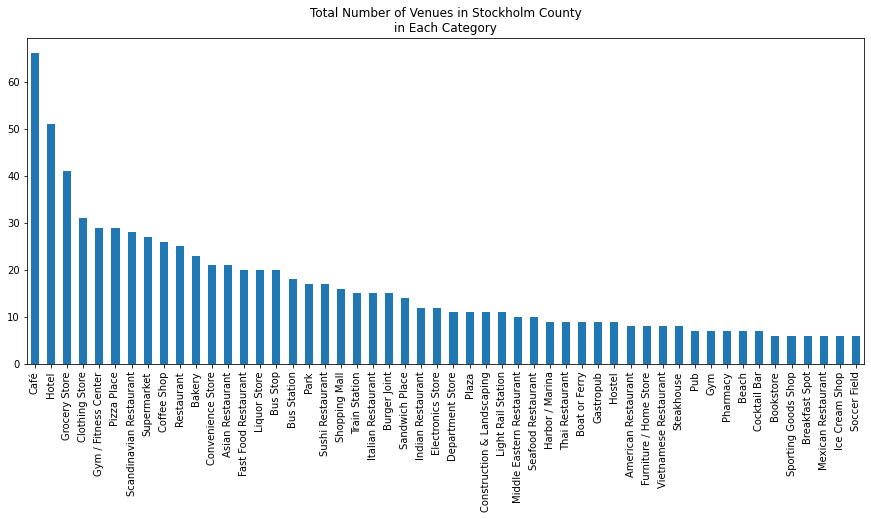

In [13]:
most_common_venues = stockholm_venues['VenueCategory'].value_counts().loc[lambda x: x>5].reset_index()['index']

stockholm_venues = stockholm_venues[stockholm_venues['VenueCategory'].isin(most_common_venues)]

stockholm_venues.VenueCategory.value_counts().plot(kind="bar", figsize=(15, 6), title="Total Number of Venues in Stockholm County\nin Each Category")

Pizza Places are the most common venues in Stockholm county, followed by Hotels as of 2021.

### Step 7: Pre-process the data before clustering analysis.

For clustering, we process the data to get the venue category frequency related information for neighbourhoods. First, we do a one-hot encoding of the ```VenueCategory``` column and add the ```Neighbourhood``` column in the front. Second, we group the resulting encoded data by the ```Neighbourhood``` column using mean aggregate. A higher mean value of a venue category for a neighbourhood represents the high frequency of that one.

In [14]:
# one-hot encoding
stockholm_onehot = pd.get_dummies(stockholm_venues[['VenueCategory']],
                                prefix="",
                                prefix_sep="")

# add 'Neighbourhood' column to this data frame
stockholm_onehot['Neighbourhood'] = stockholm_venues['Neighbourhood'] 

# move 'Neighbourhood' column to first position
fixed_columns = [stockholm_onehot.columns[-1]] + list(stockholm_onehot.columns[:-1])
stockholm_onehot = stockholm_onehot[fixed_columns]

# group rows by neighbourhood taking mean of frequency of occurrence of each category
stockholm_grouped = stockholm_onehot.groupby('Neighbourhood').mean().reset_index()

stockholm_grouped.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Bakery,Beach,Boat or Ferry,Bookstore,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Café,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Department Store,Electronics Store,Fast Food Restaurant,Furniture / Home Store,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Train Station,Vietnamese Restaurant
0,Arholma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.00,0.666667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bagarmossen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.250000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Bandhagen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.166667,0.0,0.0,0.083333,0.083333,0.00,0.000000,0.0,0.083333,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0
3,Blidö,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Bro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


The result here represents our clustering input. In other words, clustering will be performed on these numbers.

### Step 8: Get the top 10 most common venue categories for each neighbourhood.

After clustering, we need to examine the clusters formed to select the cluster the client would like to examine further in detail using other methods. Giving this cluster of districts to the client for their consideration is the goal of this project.

To examine the clusters, we find the top 10 most common venues for each neighbourhood. After the clustering is done, we are going to select our cluster based on this.

In [15]:
# we will look into top 10 most common venue categories
num_top_venues = 10

# define positions indicator suffixes
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new data frame structure
stockholm_venues_sorted = pd.DataFrame(columns=columns)

# add neighbourhood data
stockholm_venues_sorted['Neighbourhood'] = stockholm_grouped['Neighbourhood']

# add top 10 most common venue categories for these neighbourhoods
for ind in np.arange(stockholm_grouped.shape[0]):
    stockholm_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stockholm_grouped.iloc[ind, :],
                                                                          num_top_venues)

stockholm_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arholma,Harbor / Marina,Grocery Store,American Restaurant,Pub,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park
1,Bagarmossen,Gym / Fitness Center,Grocery Store,Bus Station,Pizza Place,American Restaurant,Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
2,Bandhagen,Light Rail Station,Fast Food Restaurant,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Café,Hotel,Train Station
3,Blidö,Bakery,American Restaurant,Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park,Pharmacy
4,Bro,Fast Food Restaurant,Convenience Store,American Restaurant,Pub,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park


### Step 9: Find the optimal K-value for K-Means clustering.

Now we start with our clustering. We use the K-Means clustering method for this. For this, we need to find the optimal K-value, the value for which we will receive optimal clusters.

We use the elbow method for this. Here, we repeatedly cluster with different K values, measure distortions or inertias (costs), and select the one where the cost plot forms an elbow (considered the optimal point). 

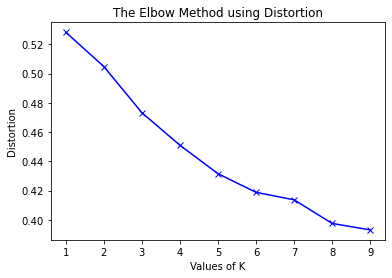

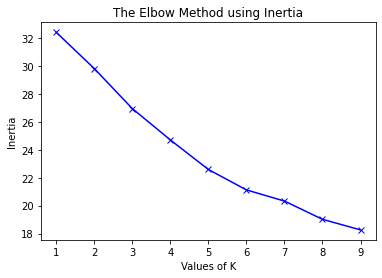

In [16]:
# find optimal k checking both distortions and inertias

# define clustering data (data on basis of which clustering is performed)
stockholm_grouped_clustering = stockholm_grouped.drop('Neighbourhood', 1)

# we will check elbow plots for distortions and inertias
distortions = []
inertias = []

# check for K ranging from 1 to 10
K = range(1, 10)

for k in K:
    # define KMeans object
    kmeans_model = KMeans(n_clusters = k, random_state=0)
    
    # fit clustering data
    kmeans_model.fit(stockholm_grouped_clustering)
 
    # calculate distortion measure
    distortions.append(sum(np.min(cdist(stockholm_grouped_clustering, kmeans_model.cluster_centers_,
                                        'euclidean'), axis = 1)) / stockholm_grouped_clustering.shape[0])
    # calculate inertia measure
    inertias.append(kmeans_model.inertia_)
    
# plot distortions elbow plot (with different Ks)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# plot inertias elbow plot (with different Ks)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

5 number of clusters seems to be the elbow and hence a good K-value.

### Step 10: Perform K-Means clustering.

We now cluster using the ```KMeans``` function and 5 as the number of clusters.

In [17]:
# fit kmeans model with 5 clusters - optimal value of k
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(stockholm_grouped_clustering)

# check cluster labels generated for each row in data frame
kmeans.labels_

array([1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 0,
       4, 1, 1, 1, 1, 1], dtype=int32)

### Step 11: Merge the cluster information with the common venues information.

This step is essential as we will use the merge data to select our cluster.

In [18]:
# combine clustering information with other data for cluster examination
stockholm_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

stockholm_merged = stockholm_data

# merge stockholm_grouped with stockholm_data to add latitude/longitude for each neighbourhood
stockholm_merged = stockholm_merged.join(stockholm_venues_sorted.set_index('Neighbourhood'),
                                     on='Neighbourhood', how='right')

stockholm_merged.head()

,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2685,Arholma,59.8500,19.1000,1,Harbor / Marina,Grocery Store,American Restaurant,Pub,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park
1799,Bagarmossen,59.2556,18.1167,1,Gym / Fitness Center,Grocery Store,Bus Station,Pizza Place,American Restaurant,Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
1651,Bandhagen,59.2968,18.0313,1,Light Rail Station,Fast Food Restaurant,Bus Station,Gym,Grocery Store,Pizza Place,Convenience Store,Café,Hotel,Train Station
2680,Blidö,59.6150,18.8917,1,Bakery,American Restaurant,Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park,Pharmacy
3474,Bro,59.5167,17.6333,1,Fast Food Restaurant,Convenience Store,American Restaurant,Pub,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park


We can check the size of our clusters. At this point, we decide whether we are satisfied with our clustering results or want to go back and change other parameters such as the number of clusters or the algorithm itself.

We like our cluster sizes and hence move forward to examine individual clusters.

In [41]:
# look at number of neighbourhoods per cluster
stockholm_merged.ClusterLabels.value_counts()

1    77
0     6
2     5
3     3
4     3
Name: ClusterLabels, dtype: int64

### Step 12: Display clustered Stockholm County neighbourhoods on the map.

Cluster exploration has to start with exploring the cluster on the map. Here we use color to distinguish districts belonging to different clusters.

In [21]:
# create map of Stockholm using latitude and longitude value
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(stockholm_merged['Latitude'],
                                  stockholm_merged['Longitude'],
                                  stockholm_merged['Neighbourhood'],
                                  stockholm_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster),
                         parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    # view clusters at end
map_clusters

##### Note: For this map result, check out https://github.com/guptasaumya/coursera-capstone/blob/master/map_clustered_neighbourhoods_Stockholm.png in this repository.

### Step 13:  Examine clusters.

It is time to examine each cluster and select the one we want to forward to the client. How we select that cluster, you ask. We look at the ```1st Most Common Venue``` column value counts. It will list how many districts have a particular venue category as their most common venue.

Since our client wants to open a pizza place, we try to see if any cluster has a pizza place as the most common venue category for most of the districts present in that cluster. Yes, read that again!

<AxesSubplot:title={'center':'Number of Districts for 1st Most Common Venue\nin Cluster 1'}>

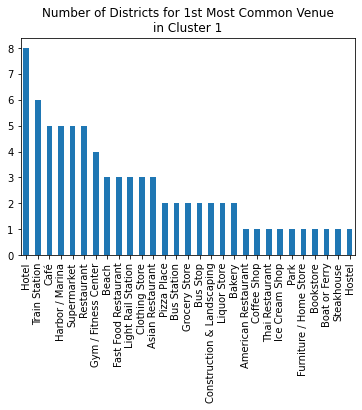

In [35]:
# Examine cluster 1
cluster_1 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 1,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_1['1st Most Common Venue'].value_counts().plot(kind="bar", y = "1st Most Common Venue", title="Number of Districts for 1st Most Common Venue\nin Cluster 1")

For cluster 1, only two districts have pizza place as their most common venue. Pizza Places do not seem to be the driving factor for all these districts belonging to cluster 1, but Hotels seem to be. Suppose these two districts already have sufficiently many pizza places. In that case, there is not much certainty of a beneficial outcome for the client's pizza place in the other districts since pizza place is not a very common venue in other districts of the cluster.

<AxesSubplot:title={'center':'Number of Districts for 1st Most Common Venue\nin Cluster 2'}>

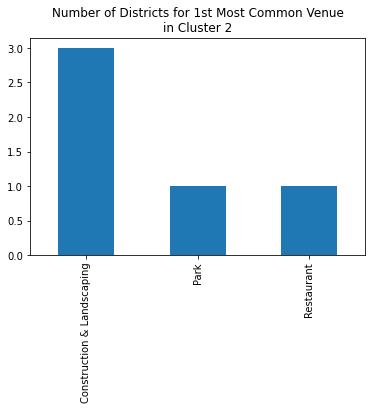

In [34]:
# Examine cluster 2
cluster_2 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 2,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_2['1st Most Common Venue'].value_counts().plot(kind="bar", y = "1st Most Common Venue", title="Number of Districts for 1st Most Common Venue\nin Cluster 2")

<AxesSubplot:title={'center':'Number of Districts for 1st Most Common Venue\nin Cluster 3'}>

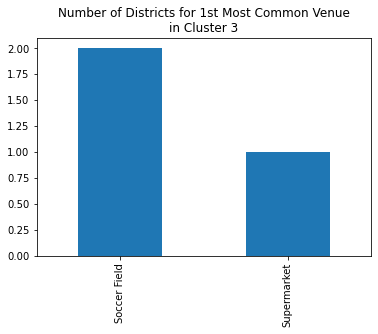

In [33]:
# Examine cluster 3
cluster_3 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 3,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_3['1st Most Common Venue'].value_counts().plot(kind="bar", y = "1st Most Common Venue", title="Number of Districts for 1st Most Common Venue\nin Cluster 3")

<AxesSubplot:title={'center':'Number of Districts for 1st Most Common Venue\nin Cluster 4'}>

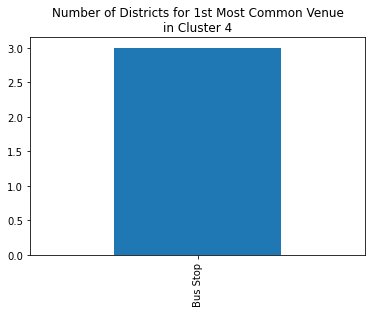

In [36]:
# Examine cluster 4
cluster_4 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 4,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_4['1st Most Common Venue'].value_counts().plot(kind="bar", y = "1st Most Common Venue", title="Number of Districts for 1st Most Common Venue\nin Cluster 4")

<AxesSubplot:title={'center':'Number of Districts for 1st Most Common Venue\nin Cluster 0'}>

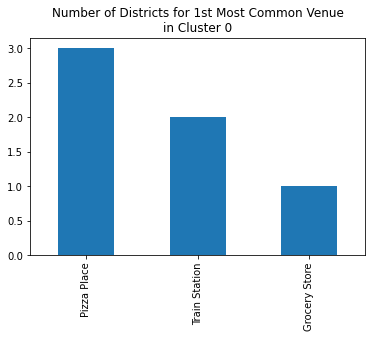

In [37]:
# Examine cluster 0
cluster_0 = stockholm_merged.loc[stockholm_merged['ClusterLabels'] == 0,
                               stockholm_merged.columns[[0] + list(range(4,
                                                                       stockholm_merged.shape[1]))]]
cluster_0['1st Most Common Venue'].value_counts().plot(kind="bar", y = "1st Most Common Venue", title="Number of Districts for 1st Most Common Venue\nin Cluster 0")

In this cluster, pizza place is the most common venue for many districts. Hence, it is evident that the districts are together in this cluster because of their score for the pizza place category.

Let us examine the districts in the cluster 0.

In [27]:
stockholm_merged[stockholm_merged['ClusterLabels'] == 0]

,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Brottby,59.5632,18.2403,0,Pizza Place,American Restaurant,Asian Restaurant,Indian Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park
2162,Enhörna,59.0500,17.4167,0,Train Station,Pizza Place,American Restaurant,Pub,Indian Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
1616,Farsta,59.2500,18.0833,0,Pizza Place,Soccer Field,American Restaurant,Pub,Indian Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
2161,Mölnbo,59.0500,17.4167,0,Train Station,Pizza Place,American Restaurant,Pub,Indian Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant
428,Tullinge,59.2000,17.8833,0,Pizza Place,Café,American Restaurant,Restaurant,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park
385,Vårby,59.2667,17.8833,0,Grocery Store,Pizza Place,American Restaurant,Ice Cream Shop,Italian Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Park


As you can see, in this cluster, 3 districts have pizza places as their first most common venue. Our client could choose to go for a location in any of these 5 districts. Suppose, for some reason (maybe, after looking at other factors such as population to pizza place venue ratio or population affordability), the client does not want to open in these districts and decides to open in any other district in this cluster. In that case, there is much certainty of the success of the pizza place. These districts belong to the same group because of their similar frequencies of the pizza places. So, if it works so well in A, but A has sufficient venues already, it will also work so well in B, which could use one more pizza place.

Voilà, I give you not just some districts whose most common venue is a pizza place, but with the power of clustering give you a group of similar districts which share the possibility of a potentially successful new pizza place. It is now in the client's hands how he/she wants to examine the districts in this cluster. 

### End of Analysis